# **Tutorial 4: Oceanic Wind-driven Circulation**

**Week 1, Day 2: Ocean and Atmospheric Reanalysis**

__Content creators:__   Abigail Bodner

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

The ocean's motion is driven by radiation from the sun, winds, and various sources & sinks of fresh water  (precipitation, rivers, melting and freezing ice). In the previous tutorial, you quantified the surface winds around the world. The surface winds drags on the surface of the ocean which results in ocean transport, known as Ekman transport.

In this tutorial you will use the [ECCO (Estimating the Circulation and Climate of the Ocean)](https://www.ecco-group.org) reanalysis data, to visualize the ocean's surface currents and to compare these currents against local atmospheric conditions.

At the end of this tutorial you will be able to

- Access and manipulate ocean reanalysis data
- Plot annual mean ocean surface currents and atmospheric surface winds
- Compare oceanic and atmospheric circulation patterns

# **Setup**

In [1]:
# !pip install pythia_datasets
# !pip install cartopy
# !pip install geoviews

In [3]:
#from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import os
import pooch

import numpy as np
import xarray as xr
import warnings
from cartopy import crs as ccrs, feature as cfeature
#  suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [4]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Load Ocean & Atmosphere Reanalysis Data**

Here you will load atmospheric near-surface winds (at 10-meter height), and then load the oceanic surface currents from ECCO reanalysis data

*Note, each of these variables is a velocity with two components (zonal and meridional). These two velocity components must be loaded separately for each variable, so you will load four datasets.*



In [4]:
# load data: atmospheric 10m wind from ECCO
# wind in east/west direction labeled here as 'u'
fname_atm_wind_u = 'wind_evel_monthly_2016.nc'
url_atm_wind_u = "https://osf.io/ke9yp/download"
atm_wind_u = xr.open_dataarray(pooch.retrieve(url_atm_wind_u, known_hash=None, fname=fname_atm_wind_u))
atm_wind_u

<xarray.DataArray 'EXFewind' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:        m/s
    long_name:    eastward 10-m wind velocity over open water, >0 increases eVel
    mate:         EXFnwind
    coordinates:  latitude timestep longitude

In [5]:
# wind in north/south direction labeled here as 'v'
fname_atm_wind_v = 'wind_nvel_monthly_2016.nc'
url_atm_wind_v = "https://osf.io/9zkgd/download"
atm_wind_v = xr.open_dataarray(pooch.retrieve(url_atm_wind_v, known_hash=None, fname=fname_atm_wind_v))
atm_wind_v

<xarray.DataArray 'EXFnwind' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:        m/s
    long_name:    northward 10-m wind velocity over open water, >0 increases ...
    mate:         EXFewind
    coordinates:  latitude timestep longitude

In [6]:
# load data: oceanic surface current from ECCO
# current in east/west direction labeled here as 'u'
fname_ocn_surface_current_u = 'evel_monthly_2016.nc'
url_ocn_surface_current_u = "https://osf.io/ndx5a/download"
ocn_surface_current_u = xr.open_dataarray(pooch.retrieve(url_ocn_surface_current_u, known_hash=None, fname=fname_ocn_surface_current_u))
ocn_surface_current_u

<xarray.DataArray 'EVEL' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16T12:00:00 ... 2014-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:          m/s
    long_name:      Eastward Component of Velocity (m/s)
    standard_name:  eastward_sea_water_velocity
    coordinates:    latitude timestep Z longitude

In [7]:
# current in east/west direction labeled here as 'v'
fname_ocn_surface_current_v = 'nvel_monthly_2016.nc'
url_ocn_surface_current_v = "https://osf.io/qa9ex/download"
ocn_surface_current_v = xr.open_dataarray(pooch.retrieve(url_ocn_surface_current_v, known_hash=None, fname=fname_ocn_surface_current_v))
ocn_surface_current_v

<xarray.DataArray 'NVEL' (time: 12, latitude: 360, longitude: 720)>
[3110400 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2014-01-16T12:00:00 ... 2014-12-16T12:00:00
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    units:          m/s
    long_name:      Northward Component of Velocity (m/s)
    standard_name:  northward_sea_water_velocity
    coordinates:    latitude timestep Z longitude

## **Section 1.1: Exploring the Reanalysis Data**

Let's examine the time (or temporal/output) frequency, which descibes the rate at which the reanalysis data is provided, for one of the ECCO variables (*atm_wind_u*). 

*Note that all the variables should have the same output frequency.*

In [8]:
atm_wind_u.time

<xarray.DataArray 'time' (time: 12)>
array(['2016-01-16T12:00:00.000000000', '2016-02-15T12:00:00.000000000',
       '2016-03-16T12:00:00.000000000', '2016-04-16T00:00:00.000000000',
       '2016-05-16T12:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2016-07-16T12:00:00.000000000', '2016-08-16T12:00:00.000000000',
       '2016-09-16T00:00:00.000000000', '2016-10-16T12:00:00.000000000',
       '2016-11-16T00:00:00.000000000', '2016-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-16T12:00:00 ... 2016-12-16T12:00:00
Attributes:
    long_name:  center time of averaging period
    bounds:     time_bnds
    axis:       T

## **Questions 1.1**
1. Why do you think the atmospheric reanalysis dataset from the previous tutorial (ERA5) has higher output frequency (hourly) than the ECCO ocean reanalysis dataset (daily)?
2. What can you infer about the role of these two systems at different timescales in the climate system?
3. What type of averaging would we need to perform on the ERA5 dataset in order to compare directly with ECCO?

In [9]:
# to_remove explanation

"""
1. The atmospheric dataset has a higher output frequency than the oceanic dataset because of the different timescales on which the atmosphere and the ocean change significantly. The atmosphere has a lower heat capacity (i.e., thermal inertia) and density than the ocean. This means that the temperature and wind speed (which is related to momentum) of the atmosphere can change rapidly (over minutes to hours), while the ocean temperature and currents change more slowly.
2. The atmosphere plays a faster, more immediate role in the climate system than the ocean. It reacts quickly to heat and pressure differences, driving weather and synoptic features. The ocean, on the other hand, plays a longer-term role in the climate system and provides a buffering effect against rapid atmospheric changes.
3. To compare the ERA5 atmospheric dataset directly with the ECCO ocean dataset, you would need to perform temporal averaging on the ERA5 data to match the output frequencies. For example, computing monthly averages from the higher-frequency atmospheric data to match the output frequency of the ECCO dataset.
""";


# **Section 2: Plotting the Annual Mean of Global Surface Wind Stress**

In this section you will create global maps displaying the annual mean of atmospheric 10m winds.

First, you should compute the annual mean of the surface wind variables. You can do so by averaging over the time dimension using `.mean(dim='time')`. Since you have monthly data spanning only one year, `.mean(dim='time')` will give the annual mean for the year 2016.


In [10]:
# compute the annual mean of atm_wind_u
atm_wind_u_an_mean = atm_wind_u.mean(dim='time')
atm_wind_u_an_mean

<xarray.DataArray 'EXFewind' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.14805873, 1.14805873, 1.14805873, ..., 1.14805873, 1.14805873,
        1.14805873],
       [1.03043525, 1.03043525, 1.03043525, ..., 1.03043525, 1.03043525,
        1.03043525],
       [0.60513089, 0.60513089, 0.60513089, ..., 0.60513089, 0.60513089,
        0.60513089]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

In [11]:
# take the annual mean of atm_wind_stress_v
atm_wind_v_an_mean = atm_wind_v.mean(dim='time')
atm_wind_v_an_mean

<xarray.DataArray 'EXFnwind' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.29360731, 0.29360731, 0.29360731, ..., 0.29360731, 0.29360731,
        0.29360731],
       [0.25386951, 0.25386951, 0.25386951, ..., 0.25386951, 0.25386951,
        0.25386951],
       [0.64899328, 0.64899328, 0.64899328, ..., 0.64899328, 0.64899328,
        0.64899328]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

You are now almost ready to plot! 

However, you currently have seperate zonal and meridional wind velocity components $(u,v)$. An effective way of visualizing the total surface wind stress is to create a global map of the *magnitude* and *direction* of the wind velocity vector. This type of plot is known as a vector field. A [vector](https://glossary.ametsoc.org/wiki/Vector) is a special mathematical quantity that has both magnitude and direction, just like the wind! The velocity components describe the intensity of wind blowing in the zonal ($u$) or meridional ($v$) directions. Specifically, wind can blow eastward (positive $u$) or westward (negative $u$), as well as northward (positive $v$) or southward (negative $v$).

The total velocity vector is the *vector sum* of these two components and exhibits varying magnitude and direction. The magnitude ($||u||$) and direction ($θ$) of the total velocity vector can be determined using the following equations:

\begin{align}
||u|| = \sqrt{u^2 + v^2},  \ \  \ \ \theta = tan^{-1}(\frac{v}{u})
\end{align}

When plotting a vector field using a computer, it is commonly referred to as a quiver plot. In our case, we will utilize a [quiver function created by Ryan Abernathey](https://rabernat.github.io/intro_to_physical_oceanography/07_ekman.html) that calculates the magnitude and direction of the total velocity vector based on the given zonal and meridional components.

We will overlay the quiver plot on top of the annual mean ocean surface temperature (labeled here as theta).

In [12]:
fname_surface_temp = 'surface_theta.nc'
url_fname_surface_temp = "https://osf.io/98ksr/download"
ocn_surface_temp = xr.open_dataarray(pooch.retrieve(url_fname_surface_temp, known_hash=None, fname=fname_surface_temp))
ocn_surface_temp

<xarray.DataArray 'THETA' (latitude: 360, longitude: 720)>
[259200 values with dtype=float64]
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...

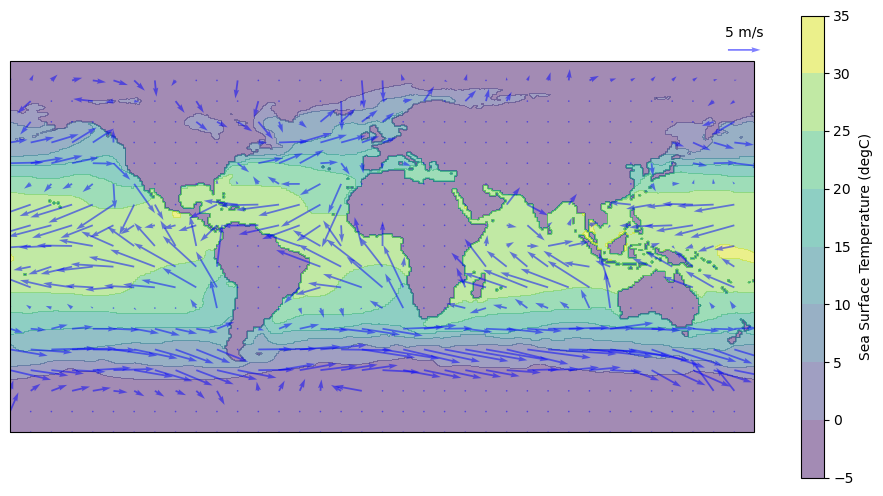

In [80]:
# longitude ad latitude coordinates for plotting
lon = atm_wind_u_an_mean.longitude
lat = atm_wind_u_an_mean.latitude

# calculate magnitude of total velocity
mag = (atm_wind_u_an_mean**2 + atm_wind_v_an_mean**2)**0.5

# coarsen the grid so the arrows are distinguishable by only selecting
# some longitudes and latitudes defined by sampling_x and sampling_y.
slx = slice(None, None, 20)
sly = slice(None, None, 20)
sl2d = (sly, slx)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

c = plt.contourf(lon,lat,ocn_surface_temp, alpha = 0.5)

# plot quiver arrows indicating vector direction (winds are in blue, alpha is for opacity)
q = ax.quiver(lon[slx],lat[sly],atm_wind_u_an_mean[sl2d],atm_wind_v_an_mean[sl2d],
          color='b', alpha=0.5)

plt.quiverkey(q, 175, 95, 5, '5 m/s', coordinates='data')

plt.colorbar(c,label = 'Sea Surface Temperature (degC)')

# Section 3: Comparing Global Maps of Surface Currents and Winds

In this section you will compute the annual mean of the ocean surface currents, similar to your above analyses of atmospheric winds, and you will create a global map that shows both of these variables simultaneously.

In [16]:
# take the annual mean of ocn_surface_current_u
ocn_surface_current_u_an_mean = ocn_surface_current_u.mean(dim='time')
ocn_surface_current_u_an_mean

<xarray.DataArray 'EVEL' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02164101, 0.02164101, 0.02164101, ..., 0.02164101, 0.02164101,
        0.02164101],
       [0.01952917, 0.01952917, 0.01952917, ..., 0.01952917, 0.01952917,
        0.01952917],
       [0.01100874, 0.01100874, 0.01100874, ..., 0.01100874, 0.01100874,
        0.01100874]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

In [17]:
# take the annual mean of ocn_surface_current_v
ocn_surface_current_v_an_mean = ocn_surface_current_v.mean(dim='time')
ocn_surface_current_v_an_mean

<xarray.DataArray 'NVEL' (latitude: 360, longitude: 720)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00707205, 0.00707205, 0.00707205, ..., 0.00707205, 0.00707205,
        0.00707205],
       [0.00721859, 0.00721859, 0.00721859, ..., 0.00721859, 0.00721859,
        0.00721859],
       [0.01465764, 0.01465764, 0.01465764, ..., 0.01465764, 0.01465764,
        0.01465764]])
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8

Let's add ocean surface currents to the previous plot above, using **red** quivers. Note the scale of the arrows for the ocean and atmosphere are very different.

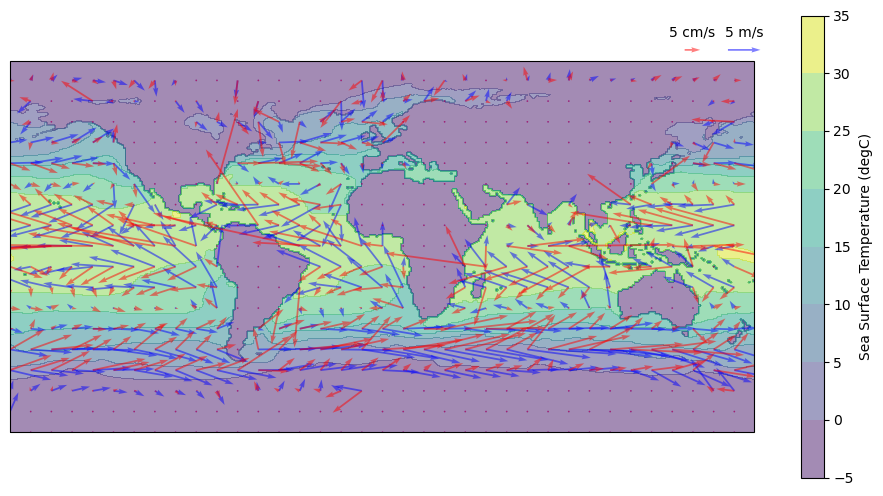

In [81]:
# longitude ad latitude coordinates for plotting
lon = atm_wind_u_an_mean.longitude
lat = atm_wind_u_an_mean.latitude

# calculate magnitude of total velocity
mag = (atm_wind_u_an_mean**2 + atm_wind_v_an_mean**2)**0.5

# coarsen the grid so the arrows are distinguishable by only selecting
# some longitudes and latitudes defined by sampling_x and sampling_y.
slx = slice(None, None, 20)
sly = slice(None, None, 20)
sl2d = (sly, slx)

#fig, ax = plt.subplots(**kwargs)
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

c = plt.contourf(lon,lat,ocn_surface_temp, alpha=0.5)

# plot quiver arrows indicating vector direction (winds are in blue, alpha is for opacity)
q1 = ax.quiver(lon[slx],lat[sly],atm_wind_u_an_mean[sl2d],atm_wind_v_an_mean[sl2d],color='b', alpha=0.5)

# plot quiver arrows indicating vector direction (ocean currents are in red, alpha is for opacity)
q2 = ax.quiver(lon[slx],lat[sly],ocn_surface_current_u_an_mean[sl2d],ocn_surface_current_v_an_mean[sl2d],color='r', alpha=0.5)

plt.quiverkey(q1, 175, 95, 5, '5 m/s', coordinates='data')

plt.quiverkey(q2, 150, 95, .05, '5 cm/s', coordinates='data')

plt.colorbar(c,label = 'Sea Surface Temperature (degC)')

### **Questions 3**

You may notice that the surface currents (red) are typically not aligned with the wind direction (blue). In fact, the surface ocean currents flow at an angle of approximately 45 degrees to the wind direction! 

The combination of [Coriolis force](https://en.wikipedia.org/wiki/Coriolis_force) and the friction between ocean layers causes the wind-driven currents to turn and weaken with depth, eventually dissapearing entirely at depth. The resulting current *profile* is called the **[Ekman Spiral](https://en.wikipedia.org/wiki/Ekman_spiral)**, and the depth over which the spiral is present is called the **Ekman layer**. While the shape of this spiral can vary in time and space, the depth-integrated transport of water within the Ekman layer is called [**Ekman transport**](https://en.wikipedia.org/wiki/Ekman_transport). Ekman transport is always *90 degrees to the right* of the wind in the Northern Hemisphere, and 90 degrees to the *left* of the wind in the Southern Hemisphere. Under certain wind patterns or near coastlines, Ekman transport can lead to **Ekman Pumping**, where water is upwelled or downwelled depending on the wind direction. This process is particularily important for coastal ecosystems that rely on this upwelling (which is often seasonal) to bring nutrient-rich waters near the surface. These nutrients fuel the growth of tiny marine plants that support the entire food chain, upon which coastal economies often rely. These tiny plants are also responsible for most of the oxygen we breathe!

1. Do you observe a deflection of the surface currents relative to the wind? 
2. Is this deflection the same in both the Northern and Southern Hemispheres?


In [77]:
# to_remove explanation

""" 
1. Yes, the surface currents are deflected relative to the surface winds, and this seems to happen globally.
2. The deflection of the ocean surface current is to the left of the wind in the Southern Hemisphere, and is to the right of the wind in the Northern Hemisphere. This property is predicted by Ekman flow.
""";

# **Summary**


In this tutorial, you explored how atmospheric winds can shape ocean surface currents.

You calculated the surface wind vector an assessed its influence on surface ocean currents called the wind-driven circulation.

This circulation influences global climate (e.g., moving heat between latitudes) and biogeochemical cycles (e.g., by driving upwelling of nutrient rich water). In the next tutorial you will explore another mechanism for ocean movement, *density-driven circulation*.


# **Resources**

Data for this tutorial can be accessed [here](https://www.ecco-group.org/).